# Import statements

In [1]:
from google.colab import drive
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset 1: Wiki1M abstracts

In [2]:
embedding_Wiki1M = '/content/drive/MyDrive/output/Wiki1M/embeddings.npy'  # update this
embeddings_Wiki1M = np.load(embedding_Wiki1M)

embedding_keys_1 = '/content/drive/MyDrive/output/Wiki1M/keys.npy'  # update this
keys_Wiki1M = np.load(embedding_keys_1)

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Generated_Titles.csv')

In [4]:
df

,Original Filename,Generated Title
0,Chapter_1_.txt,Update to Machine Learning Introductory Book: ...
1,Chapter_2_.txt,Acknowledgements and Overview of Neural Networ...
2,Chapter_3_.txt,Understanding Machine Learning: A Probabilisti...
3,Chapter_4_.txt,Introduction to Classification in Supervised M...
4,Chapter_5_.txt,Exploratory Data Analysis for Machine Learning...
...,...,...
385,Chapter_386_.txt,Link Prediction and Graph Embeddings in Financ...
386,Chapter_387_.txt,Graph Embeddings for Graph Classification in M...
387,Chapter_388_.txt,Linear Algebra: Notation and Standard Notation...
388,Chapter_389_.txt,Matrix Calculus and Optimization Notation


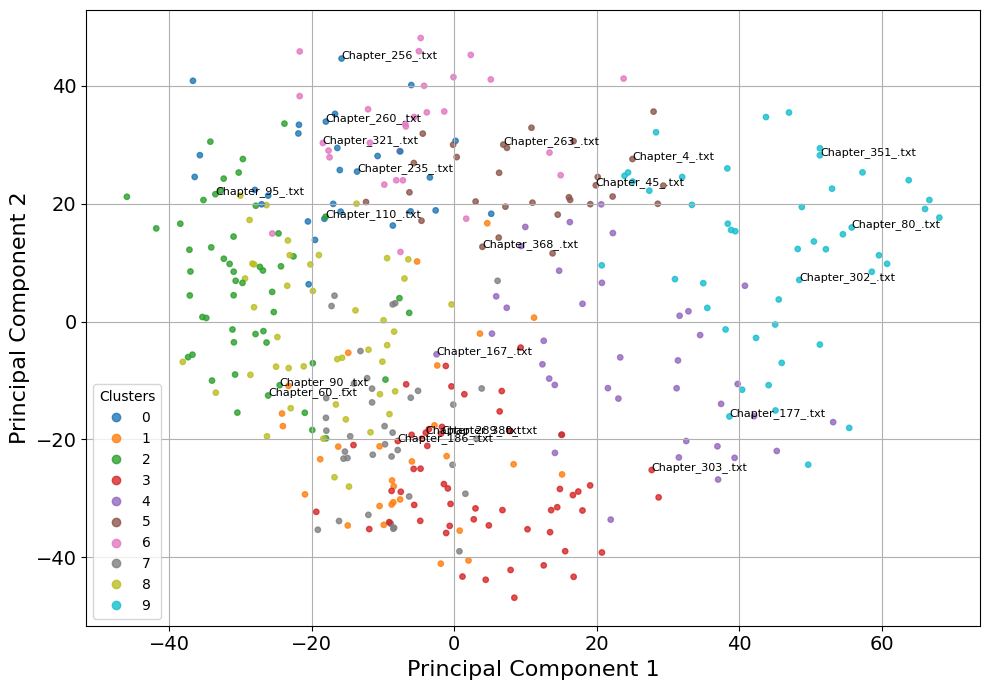

In [5]:
'''
I looked up code on how to find the 10 closest data points and
store it in a csv from the cluster centroids using OpenAI
'''
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_Wiki1M)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_Wiki1M)

centroids = kmeans.cluster_centers_
distances = cdist(embeddings_Wiki1M, centroids, 'euclidean')

top_n = 10
representative_points = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]
    sorted_indices = cluster_indices[np.argsort(cluster_distances)]
    representative_points[cluster_id] = {
        'filenames': [keys_Wiki1M[i] for i in sorted_indices[:top_n]],
        'distances': cluster_distances[np.argsort(cluster_distances)][:top_n]
    }

output_data = []

for cluster_id, data in representative_points.items():
    for filename, dist in zip(data['filenames'], data['distances']):
        matched_row = df[df['Original Filename'] == filename]
        if not matched_row.empty:
            actual_name = matched_row['Generated Title'].values[0]
        else:
            actual_name = filename
        output_data.append([cluster_id, actual_name, dist])

output_df = pd.DataFrame(output_data, columns=['Cluster ID', 'Actual Name', 'Distance'])
output_df.to_csv('/content/drive/My Drive/representative_points_Wiki1M_FirstTry.csv', index=False)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab10',
    s=15, alpha=0.8
)

for i in range(0, len(keys_Wiki1M), len(keys_Wiki1M)//20):
    plt.annotate(str(keys_Wiki1M[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.savefig('/content/drive/My Drive/pca_clusters_Wiki1M.png')
plt.show()

In [6]:
output_df

,Cluster ID,Actual Name,Distance
0,0,Neural Networks and Training for Tabular Data,53.164978
1,0,Neural Networks: Transformers and Their Archit...,56.713645
2,0,Neural Networks for Tabular Data: Regularizati...,57.330792
3,0,Neural Networks for Sequences and Transformers...,57.833384
4,0,Graph Embeddings: Euclidean vs. Non-Euclidean ...,58.131614
...,...,...,...
95,9,Bernoulli Mixture Models for Clustering Binary...,58.238067
96,9,Dimensionality Reduction Techniques in Probabi...,58.308649
97,9,Regularization in Statistics: Understanding an...,58.379291
98,9,Comparison of Linear Regression Techniques: La...,58.740467


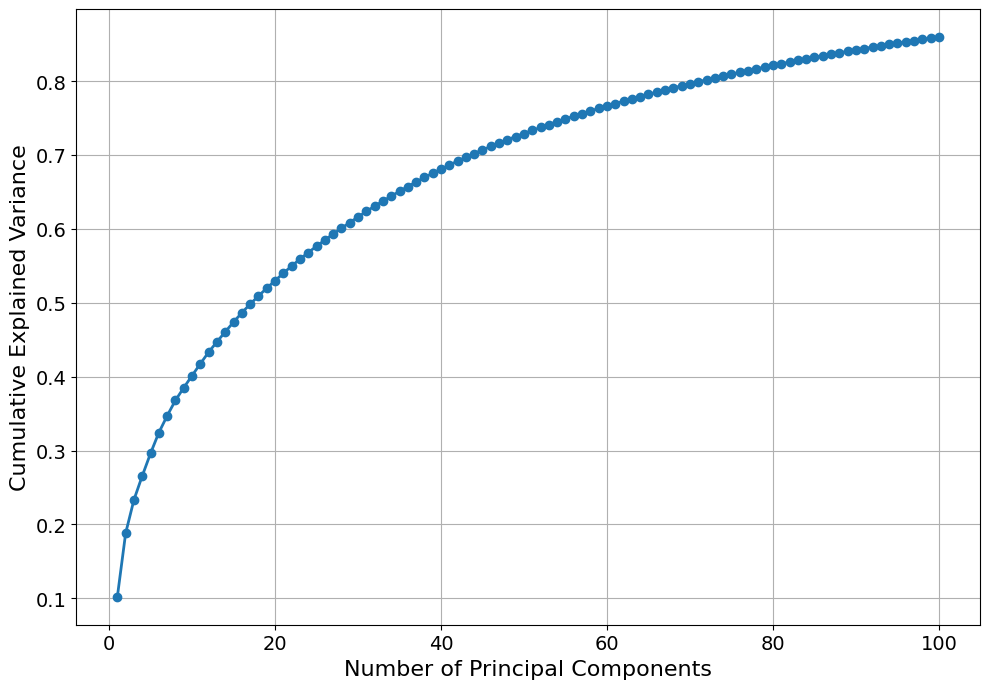

In [7]:
pca = PCA(n_components=100)
pca.fit(embeddings_Wiki1M)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)

plt.xlabel('Number of Principal Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/cumulative_Variance_Wiki1M.png')
plt.show()

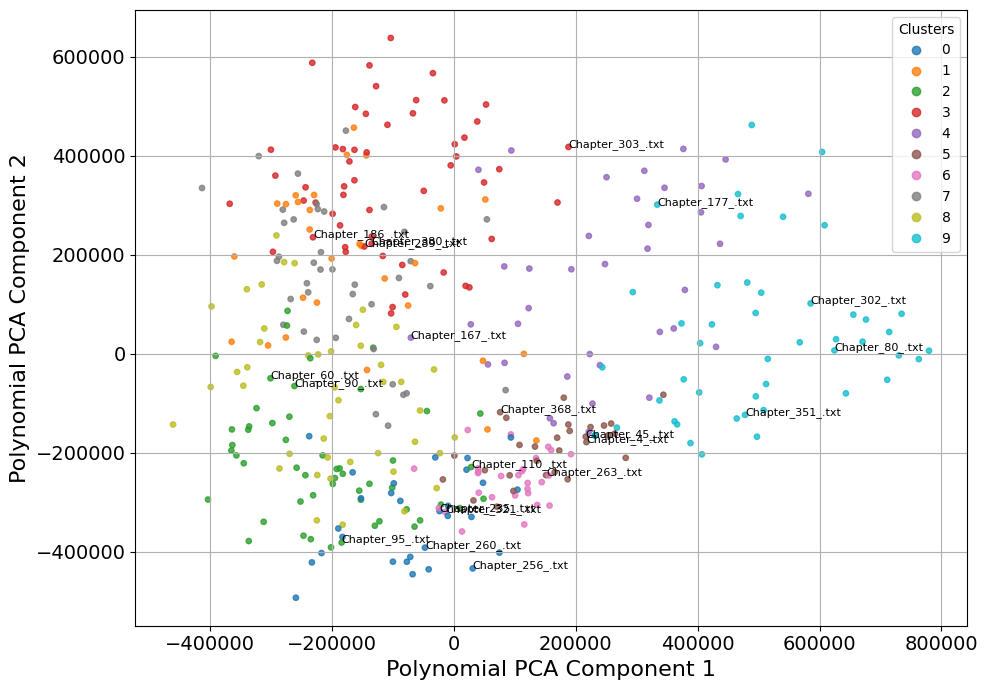

In [8]:
kpca = KernelPCA(n_components=2, kernel='poly', degree=3, coef0=1, gamma=1)
embeddings_2d = kpca.fit_transform(embeddings_Wiki1M)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_Wiki1M)

# Find the centroids of each cluster
centroids = kmeans.cluster_centers_

# Calculate the Euclidean distance from each point to its cluster's centroid
distances = cdist(embeddings_Wiki1M, centroids, 'euclidean')

# For each cluster, find the 10 closest points
top_n = 10
representative_points = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]  # Get indices of points in the current cluster

    cluster_distances = distances[cluster_indices, cluster_id]

    sorted_indices = cluster_indices[np.argsort(cluster_distances)]

    representative_points[cluster_id] = {
        'filenames': [keys_Wiki1M[i] for i in sorted_indices[:top_n]],  # Get the filenames of the top 10 closest points
        'distances': cluster_distances[np.argsort(cluster_distances)][:top_n]  # Get the corresponding distances
    }

output_data = []

for cluster_id, data in representative_points.items():
    for filename, dist in zip(data['filenames'], data['distances']):
        matched_row = df[df['Original Filename'] == filename]
        if not matched_row.empty:
            actual_name = matched_row['Generated Title'].values[0]
        else:
            actual_name = filename  # If not found, keep the filename as it is

        output_data.append([cluster_id, actual_name, dist])

output_df = pd.DataFrame(output_data, columns=['Cluster ID', 'Actual Name', 'Distance'])

output_df.to_csv('/content/drive/My Drive/representative_points_kernelpca_Wiki1M.csv', index=False)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab10',
    s=15, alpha=0.8
)

for i in range(0, len(keys_Wiki1M), len(keys_Wiki1M)//20):
    plt.annotate(str(keys_Wiki1M[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('Polynomial PCA Component 1', fontsize=16)
plt.ylabel('Polynomial PCA Component 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/kernelPCA_Wiki1M.png')
plt.show()



In [9]:
output_df

,Cluster ID,Actual Name,Distance
0,0,Neural Networks and Training for Tabular Data,53.164978
1,0,Neural Networks: Transformers and Their Archit...,56.713645
2,0,Neural Networks for Tabular Data: Regularizati...,57.330792
3,0,Neural Networks for Sequences and Transformers...,57.833384
4,0,Graph Embeddings: Euclidean vs. Non-Euclidean ...,58.131614
...,...,...,...
95,9,Bernoulli Mixture Models for Clustering Binary...,58.238067
96,9,Dimensionality Reduction Techniques in Probabi...,58.308649
97,9,Regularization in Statistics: Understanding an...,58.379291
98,9,Comparison of Linear Regression Techniques: La...,58.740467


#Dataset 2: arXiv abstracts

In [10]:
embedding_arxivAbstract = '/content/drive/MyDrive/output/arXivAbstracts/embeddings.npy'  # update this
embeddings_arxivAbstract = np.load(embedding_arxivAbstract)

embedding_keys_2 = '/content/drive/MyDrive/output/arXivAbstracts/keys.npy'  # update this
keys_arxivAbstract= np.load(embedding_keys_2)

Explained variance ratio: [0.07297391 0.0530788 ]


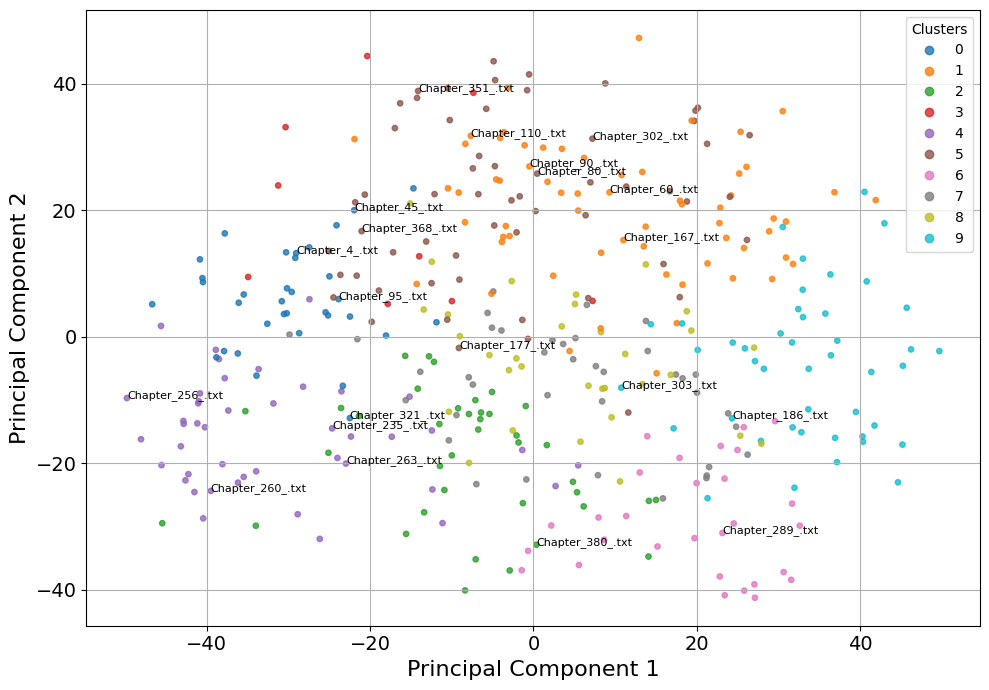

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_arxivAbstract)

print("Explained variance ratio:", pca.explained_variance_ratio_)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_arxivAbstract)

centroids = kmeans.cluster_centers_
distances = cdist(embeddings_arxivAbstract, centroids, 'euclidean')

top_n = 10
representative_points = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]
    sorted_indices = cluster_indices[np.argsort(cluster_distances)]
    representative_points[cluster_id] = {
        'filenames': [keys_arxivAbstract[i] for i in sorted_indices[:top_n]],
        'distances': cluster_distances[np.argsort(cluster_distances)][:top_n]
    }

output_data = []

for cluster_id, data in representative_points.items():
    for filename, dist in zip(data['filenames'], data['distances']):
        matched_row = df[df['Original Filename'] == filename]
        if not matched_row.empty:
            actual_name = matched_row['Generated Title'].values[0]
        else:
            actual_name = filename
        output_data.append([cluster_id, actual_name, dist])

output_df = pd.DataFrame(output_data, columns=['Cluster ID', 'Actual Name', 'Distance'])
output_df.to_csv('/content/drive/My Drive/representative_points_arxivAbstract_pca.csv', index=False)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab10',
    s=15, alpha=0.8
)

for i in range(0, len(keys_arxivAbstract), len(keys_arxivAbstract)//20):
    plt.annotate(str(keys_arxivAbstract[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/arxivAbstract_pca.png')
plt.show()

In [12]:
output_df

,Cluster ID,Actual Name,Distance
0,0,Introduction to Classification in Supervised M...,78.588404
1,0,Clustering Animals Based on Features,79.249257
2,0,Semi-Supervised Learning with Generative Adver...,79.833262
3,0,"""Biclustering in Organism and Feature Classifi...",80.510285
4,0,"Comparison of MNIST, Fashion-MNIST, and CIFAR-...",80.914714
...,...,...,...
94,9,Linear Discriminant Analysis for Binary Classi...,59.643967
95,9,Support Vector Machines and Kernel Methods for...,60.239002
96,9,"""Statistical Inference Through Maximum Likelih...",61.314545
97,9,Normalizing a Gaussian Distribution and Unders...,61.622997


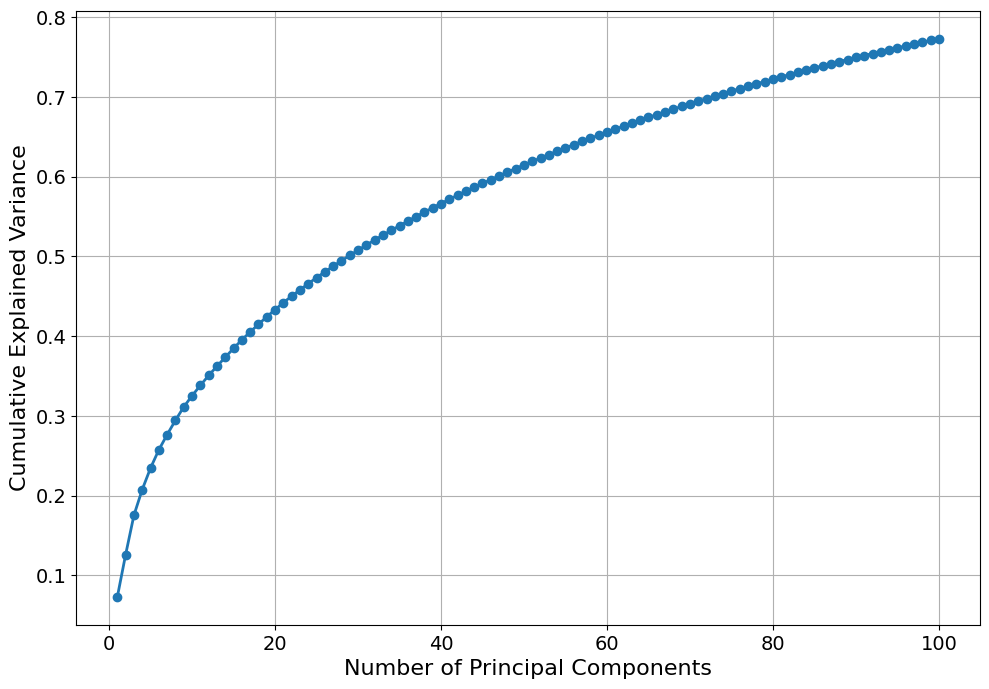

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=100)  # Fit PCA with more components for detailed analysis
pca.fit(embeddings_arxivAbstract)

# Get cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)

plt.xlabel('Number of Principal Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/arxivAbstract_CumulativeVariance_pca.png')
plt.show()


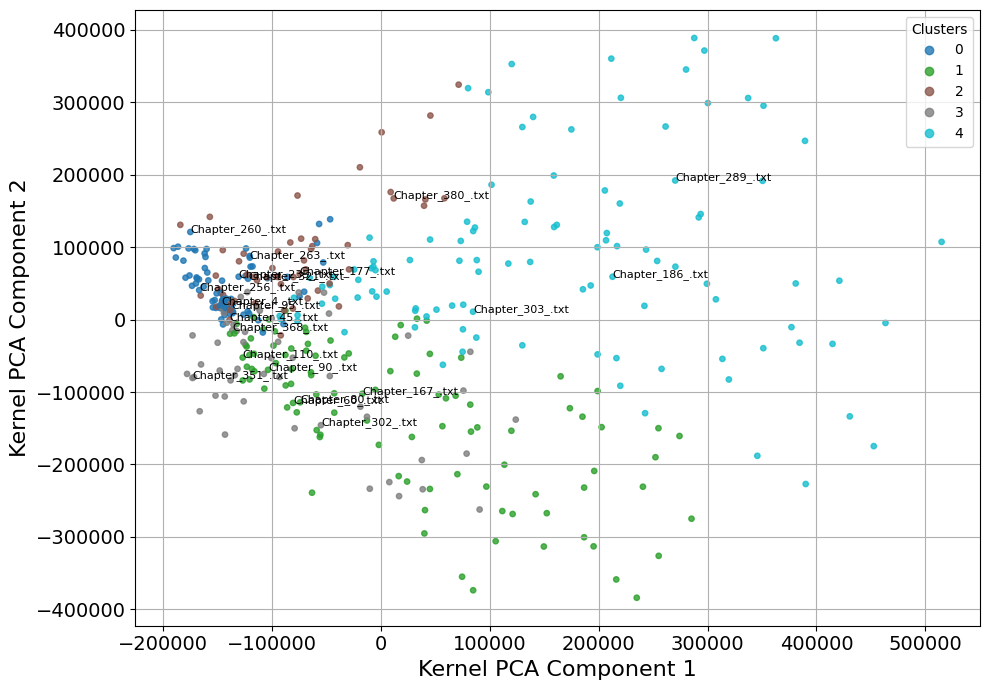

In [14]:
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

kpca = KernelPCA(n_components=2, kernel='poly', degree=3, coef0=1, gamma=1)
embeddings_2d = kpca.fit_transform(embeddings_arxivAbstract)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_arxivAbstract)

centroids = kmeans.cluster_centers_
distances = cdist(embeddings_arxivAbstract, centroids, 'euclidean')

top_n = 10
representative_points = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]
    sorted_indices = cluster_indices[np.argsort(cluster_distances)]
    representative_points[cluster_id] = {
        'filenames': [keys_arxivAbstract[i] for i in sorted_indices[:top_n]],
        'distances': cluster_distances[np.argsort(cluster_distances)][:top_n]
    }

output_data = []

for cluster_id, data in representative_points.items():
    for filename, dist in zip(data['filenames'], data['distances']):
        matched_row = df[df['Original Filename'] == filename]
        if not matched_row.empty:
            actual_name = matched_row['Generated Title'].values[0]
        else:
            actual_name = filename
        output_data.append([cluster_id, actual_name, dist])

output_df = pd.DataFrame(output_data, columns=['Cluster ID', 'Actual Name', 'Distance'])
output_df.to_csv('/content/drive/My Drive/representative_points_arxivAbstract_kernelPCA.csv', index=False)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab10',
    s=15, alpha=0.8
)

for i in range(0, len(keys_arxivAbstract), len(keys_arxivAbstract)//20):
    plt.annotate(str(keys_arxivAbstract[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('Kernel PCA Component 1', fontsize=16)
plt.ylabel('Kernel PCA Component 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/arxivAbstract_kernelPCA.png')
plt.show()

In [15]:
output_df

,Cluster ID,Actual Name,Distance
0,0,Neural Networks for Sequence Modeling,72.434519
1,0,Neural Networks for Sequences,75.031888
2,0,Neural Networks for Tabular Data: Regularizati...,77.883470
3,0,Neural Networks for Sequences: BERT and Fine-t...,78.001327
4,0,Neural Networks for Text Classification with MLPs,79.646551
5,0,Neural Networks for Image Classification,80.054253
6,0,Semi-Supervised Learning with Generative Adver...,80.093278
7,0,Neural Networks for Generating Variable-Length...,80.183825
8,0,Neural Networks for Various Data Types,80.468780
9,0,Understanding 2D Convolution in Neural Networks,80.602706


# Dataset 3: arXiv Titles

In [16]:
embedding_arxivTitles = '/content/drive/MyDrive/output/arXivTitles/embeddings.npy'  # update this
embeddings_arxivTitles = np.load(embedding_arxivTitles)

embedding_keys_3 = '/content/drive/MyDrive/output/arXivTitles/keys.npy'  # update this
keys_arxivTitles = np.load(embedding_keys_3)

Explained variance ratio: [0.09817459 0.08217406]


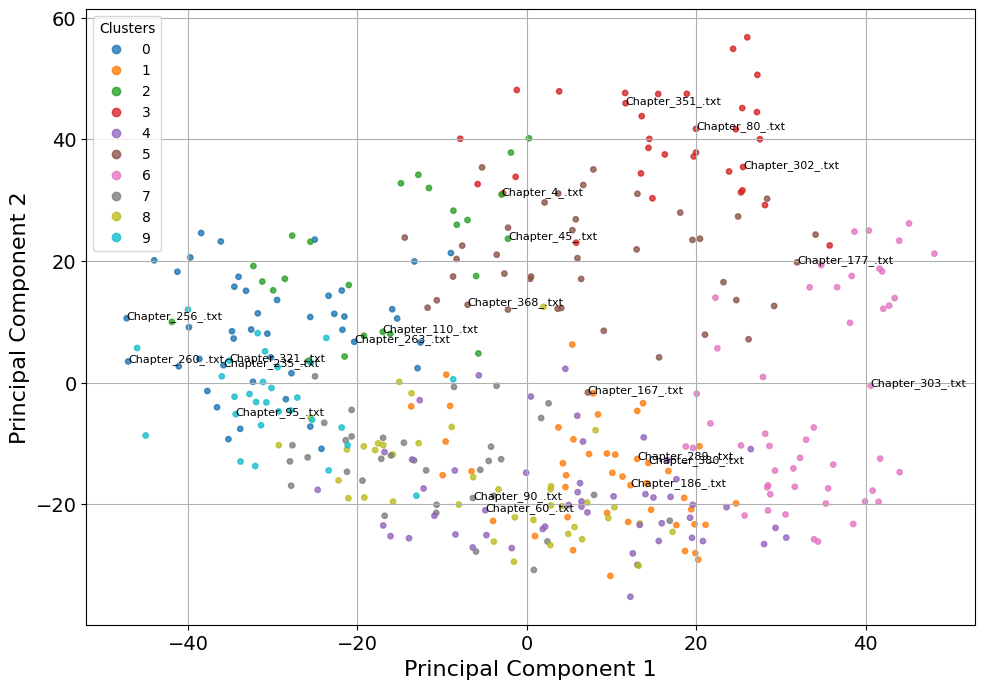

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_arxivTitles)

print("Explained variance ratio:", pca.explained_variance_ratio_)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_arxivTitles)

centroids = kmeans.cluster_centers_
distances = cdist(embeddings_arxivTitles, centroids, 'euclidean')

top_n = 10
representative_points = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]
    sorted_indices = cluster_indices[np.argsort(cluster_distances)]
    representative_points[cluster_id] = {
        'filenames': [keys_arxivTitles[i] for i in sorted_indices[:top_n]],
        'distances': cluster_distances[np.argsort(cluster_distances)][:top_n]
    }

output_data = []

for cluster_id, data in representative_points.items():
    for filename, dist in zip(data['filenames'], data['distances']):
        matched_row = df[df['Original Filename'] == filename]
        if not matched_row.empty:
            actual_name = matched_row['Generated Title'].values[0]
        else:
            actual_name = filename
        output_data.append([cluster_id, actual_name, dist])

output_df = pd.DataFrame(output_data, columns=['Cluster ID', 'Actual Name', 'Distance'])
output_df.to_csv('/content/drive/My Drive/representative_points_arxivTitles_pca.csv', index=False)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab10',
    s=15, alpha=0.8
)

for i in range(0, len(keys_arxivTitles), len(keys_arxivTitles)//20):
    plt.annotate(str(keys_arxivTitles[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/arxivTitles_pca.png')
plt.show()

In [18]:
output_df

,Cluster ID,Actual Name,Distance
0,0,Extensions of Convolution in Neural Networks f...,56.277080
1,0,Neural Networks for Sequences and Wavenet Mode...,57.942531
2,0,Neural Networks and Training for Tabular Data,58.971088
3,0,Neural Networks for Tabular Data: Regularizati...,59.486333
4,0,Neural Networks for Sequences and Transformers...,59.625962
...,...,...,...
95,9,Consistency Regularization for Semi-Supervised...,63.032519
96,9,Precision-Recall Curves in Decision Theory,63.743972
97,9,Semi-Supervised Learning with Generative Adver...,63.832579
98,9,Recommender Systems: Collaborative Filtering a...,63.880685


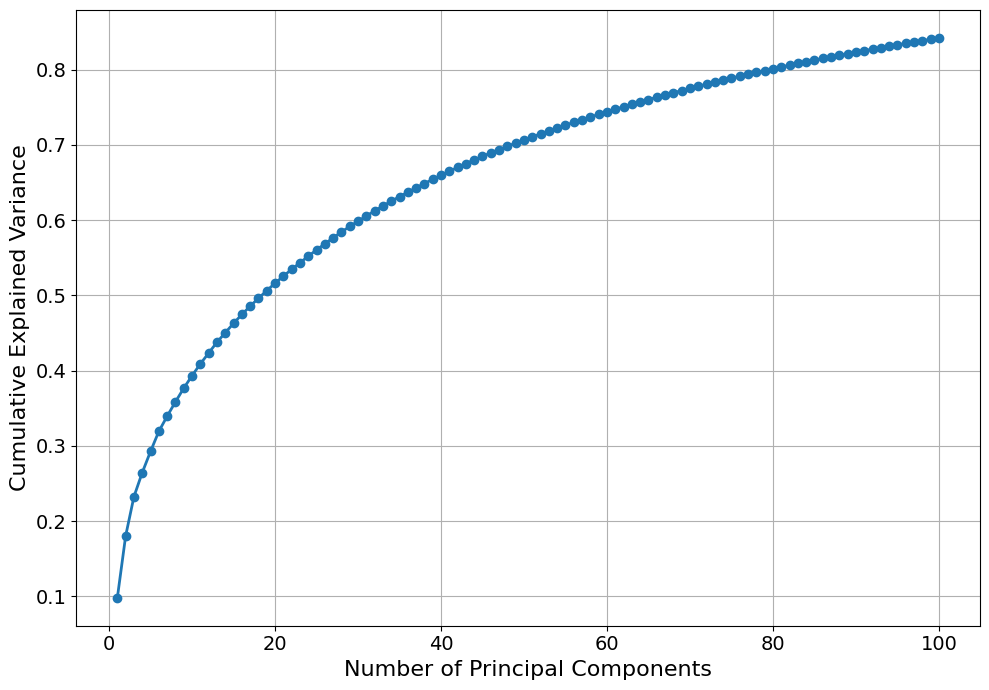

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=100)
pca.fit(embeddings_arxivTitles)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)

plt.xlabel('Number of Principal Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/arxivTitle_cumulativeVariance_pca.png')
plt.show()


# Medium Titles

In [21]:
mediumTitles = '/content/drive/MyDrive/output/AllMediumTitles/embeddings.npy'  # update this
embeddings_mediumTitles = np.load(mediumTitles)

embedding_mediumTitles = '/content/drive/MyDrive/output/AllMediumTitles/keys.npy'  # update this
keys_mediumTitles = np.load(embedding_mediumTitles)

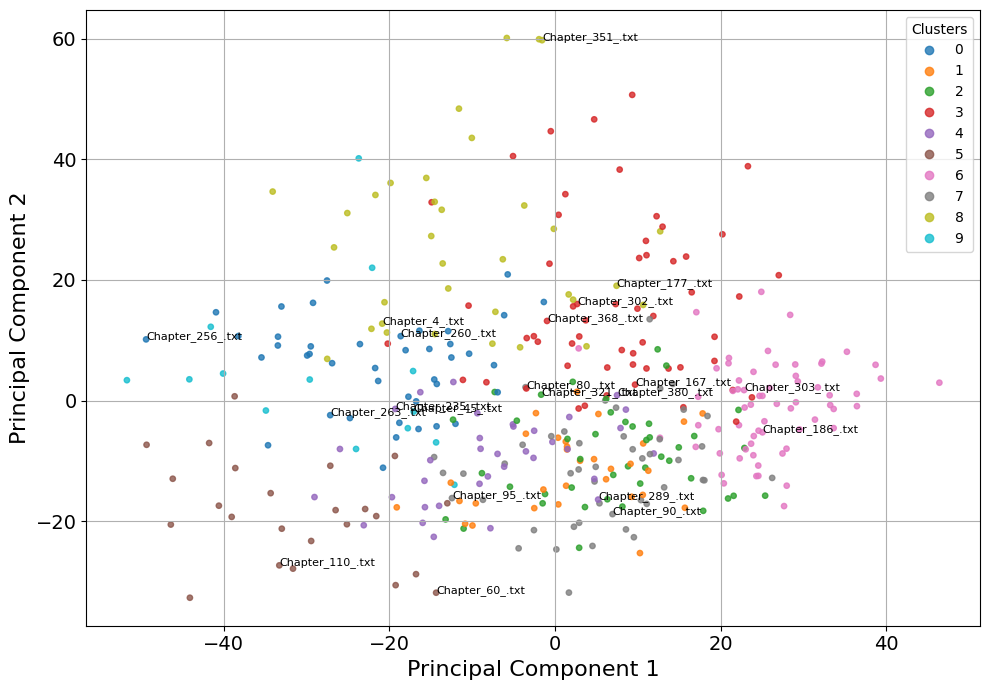

In [26]:
'''
I looked up code on how to find the 10 closest data points and
store it in a csv from the cluster centroids using OpenAI
'''
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_mediumTitles)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_mediumTitles)

centroids = kmeans.cluster_centers_
distances = cdist(embeddings_mediumTitles, centroids, 'euclidean')

top_n = 10
representative_points = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_distances = distances[cluster_indices, cluster_id]
    sorted_indices = cluster_indices[np.argsort(cluster_distances)]
    representative_points[cluster_id] = {
        'filenames': [keys_mediumTitles[i] for i in sorted_indices[:top_n]],
        'distances': cluster_distances[np.argsort(cluster_distances)][:top_n]
    }

output_data = []

for cluster_id, data in representative_points.items():
    for filename, dist in zip(data['filenames'], data['distances']):
        matched_row = df[df['Original Filename'] == filename]
        if not matched_row.empty:
            actual_name = matched_row['Generated Title'].values[0]
        else:
            actual_name = filename
        output_data.append([cluster_id, actual_name, dist])

output_df = pd.DataFrame(output_data, columns=['Cluster ID', 'Actual Name', 'Distance'])
output_df.to_csv('/content/drive/My Drive/representative_points_embeddings_mediumTitles.csv', index=False)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab10',
    s=15, alpha=0.8
)

for i in range(0, len(keys_mediumTitles), len(keys_mediumTitles)//20):
    plt.annotate(str(keys_mediumTitles[i]), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.savefig('/content/drive/My Drive/pca_clusters_mediumTitles.png')
plt.show()

In [27]:
output_df

,Cluster ID,Actual Name,Distance
0,0,Neural Networks for Sequences and Transformers...,37.431746
1,0,Dimensionality Reduction Techniques: Autoencod...,40.929594
2,0,Graph Embeddings: Advancements through GraphSA...,42.115169
3,0,Neural Networks: Transformers and Their Archit...,42.341514
4,0,Handling Novel Words in Word Embeddings and Te...,42.619222
...,...,...,...
95,9,Neural Networks for Sequences and Named Entity...,53.132554
96,9,NLP Tasks: Text Classification and Machine Tra...,53.960908
97,9,Hierarchical Classification with Logistics Reg...,55.044644
98,9,Acknowledgements and Overview of Neural Networ...,57.762057


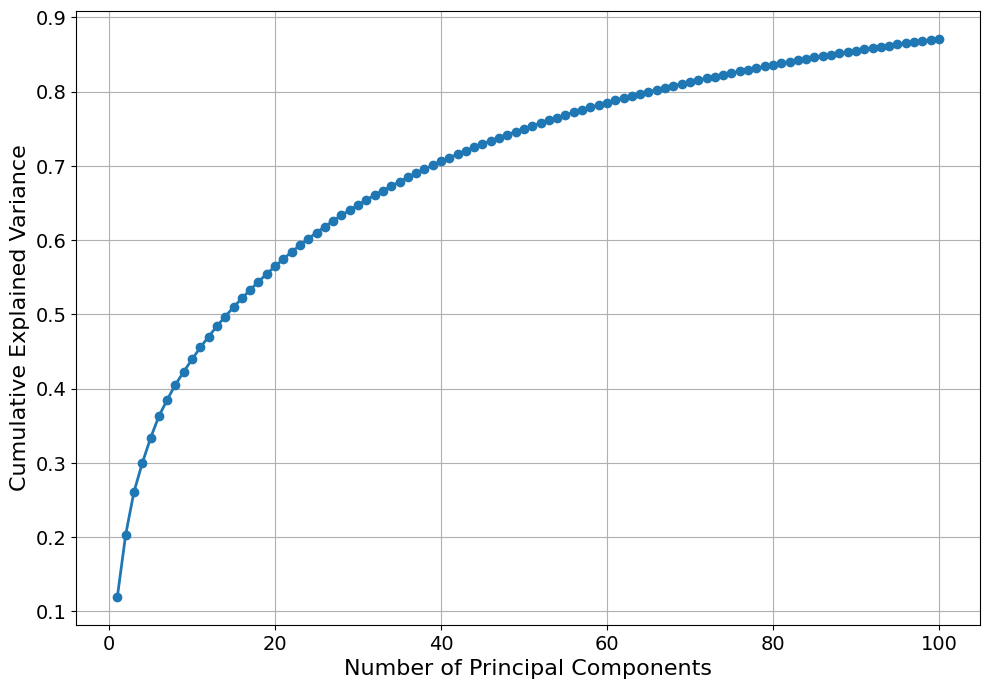

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=100)
pca.fit(embeddings_mediumTitles)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)

plt.xlabel('Number of Principal Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/mediumTitles_cumulativeVariance_pca.png')
plt.show()